- Now using the sklearn Pipeline 
- Fixed the implementation of OneHot Encoding, it doesn't increase MSEs anymore (it was a coding mistake of course) but decreases them slightly
- Summarized two rain categories into one
- missing
    - Remove year as feature
    - Regularization
    - Grid-Search for the trees
    - Random Forest
    - Quantile Regression

- Implemented (linear) time feature engineering and time-based cross-validation

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('data/raw/weather-hour.csv')

In [ ]:
weather = df.iloc[:,1:].copy()

In [ ]:
weather.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
weather["cnt"].describe()
# min = 1
# max = 977

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

### Preprocessing:

In [ ]:
# find missing values
weather.isnull().sum()

dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [ ]:
weather.shape

(17379, 16)

In [ ]:
X = weather.drop(columns=["casual", "registered", "cnt"]) # removing target variables
y = weather["cnt"]

In [ ]:
# feature engineering: removing date column
X = X.drop(columns=["dteday"])

In [ ]:
X["weathersit"].value_counts()
# 1 clear
# 2 misty
# 3 rain
# 4 heavy rain

weathersit
1    11413
2     4544
3     1419
4        3
Name: count, dtype: int64

In [ ]:
X["weathersit"] = (
    X["weathersit"]
    .replace(to_replace=4, value=3)
)

In [ ]:
X["weathersit"].value_counts()

weathersit
1    11413
2     4544
3     1422
Name: count, dtype: int64

In [ ]:
X["season"].value_counts() # looks good

season
3    4496
2    4409
1    4242
4    4232
Name: count, dtype: int64

### Defining evaluation functions:

In [ ]:
from sklearn.model_selection import train_test_split

seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 
#To make the validation set 20% of the original data we use test size 0.25 as 0.25*0.8=0.2

In [ ]:
from sklearn.metrics import mean_squared_error

def fit_predict_eval(pipe, X_train, y_train, X_test, y_test):
    # fit the model
    pipe.fit(X_train, y_train)

    # make predictions on the validation set
    y_train_pred = pipe.predict(X_train)

    # make predictions on the test set
    y_pred = pipe.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_pred)  

    return mse_train, mse_test, y_train_pred, y_pred

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

def fit_eval_cv(pipe, X, y):
    # fit the model
    pipe.fit(X_train, y_train)

    scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_MSE = -np.mean(scores)

    return cv_MSE

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# 1000 test datapoints represent a bit less than a month and a half of contiguous test data

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48, # 2 day = 48h gap between train & test
    max_train_size=10000,
    test_size=1000,
)

In [ ]:
def fit_eval_ts_cv(pipe, X, y, ts_cv):
    
    pipe.fit(X_train, y_train)

    scores = cross_val_score(pipe, X, y, cv=ts_cv, scoring='neg_mean_squared_error')
    cv_MSE = -np.mean(scores)

    return cv_MSE

### Models:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

pipe_LR = Pipeline(steps=[
      ('model', LinearRegression())]
      )

In [ ]:
y_pred = fit_predict_eval(pipe_LR, X_train, y_train, X_test, y_test)[3]

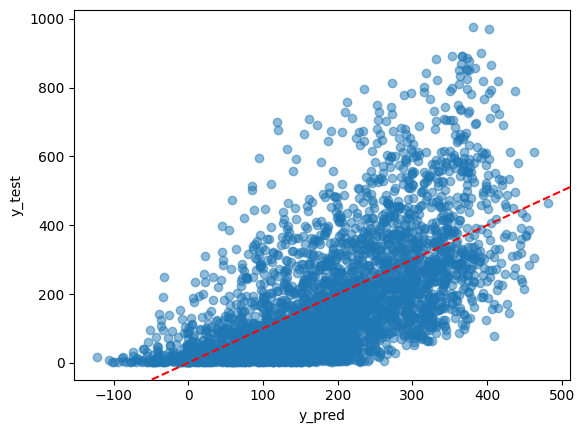

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('y_pred')
plt.ylabel('y_test')
# add the line y=x for reference
plt.axline((0, 0), slope = 1, color='red', linestyle='--') 
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

pipe_tree_3 = Pipeline(steps=[
      ('model', DecisionTreeRegressor(max_depth = 3, random_state=42))]
      )

In [ ]:
tree_model = pipe_tree_3.fit(X_train, y_train)

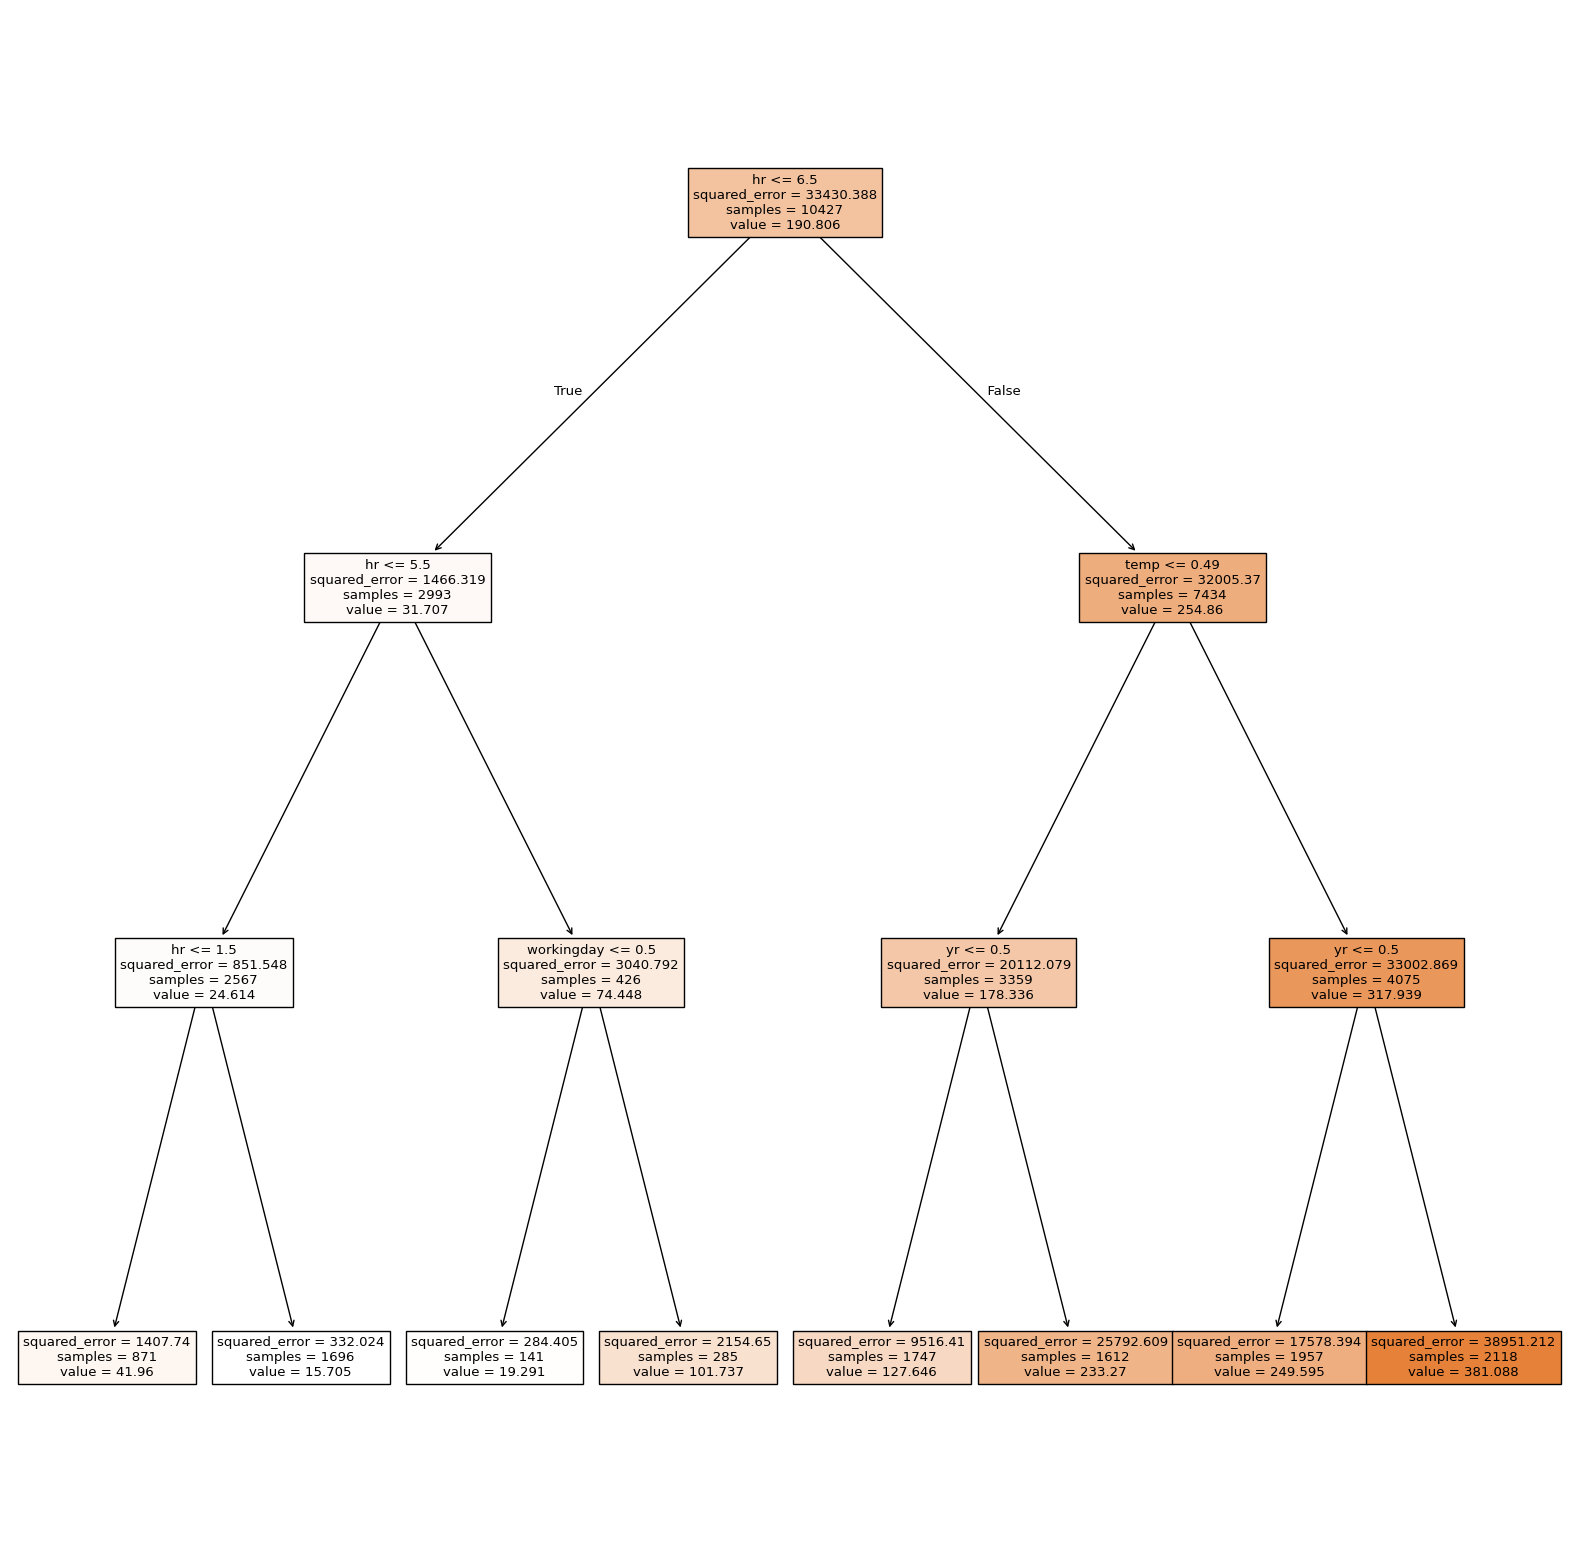

In [ ]:
#Display the regression tree
plt.figure(figsize=(20,20))
plot_tree(pipe_tree_3.named_steps['model'], feature_names = X_train.columns, filled=True)
plt.show()

In [ ]:
pipe_tree_15 = Pipeline(steps=[
      ('model', DecisionTreeRegressor(max_depth = 15, random_state=42))]
      )

### OneHot Encoding increases MSEs:

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['season', 'yr', 'weathersit']

pipe_LR_proc = Pipeline(steps=[
    ('transformer', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
        ],
        remainder='passthrough'
    )),
    ('model', LinearRegression())
])

In [ ]:
y_pred2 = fit_predict_eval(pipe_LR_proc, X_train, y_train, X_test, y_test)[3]

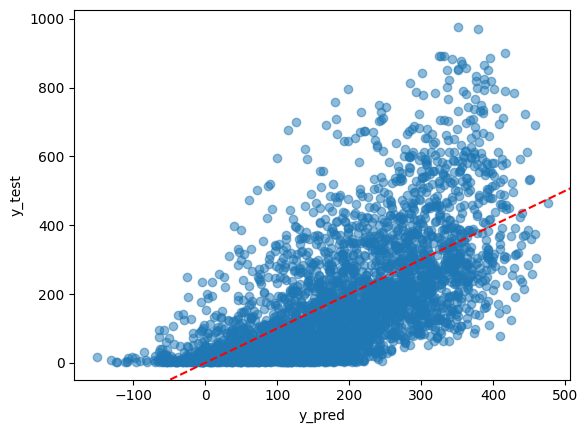

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_pred2, y_test, alpha=0.5)
plt.xlabel('y_pred')
plt.ylabel('y_test')
# add the line y=x for reference
plt.axline((0, 0), slope = 1, color='red', linestyle='--') 
plt.show()

In [ ]:
pipe_tree_3_proc = Pipeline(steps=[
    ('transformer', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
        ],
        remainder='passthrough'
    )),
    ('model', DecisionTreeRegressor(max_depth=3, random_state=42))
])

In [ ]:
tree_model = pipe_tree_3_proc.fit(X_train, y_train)

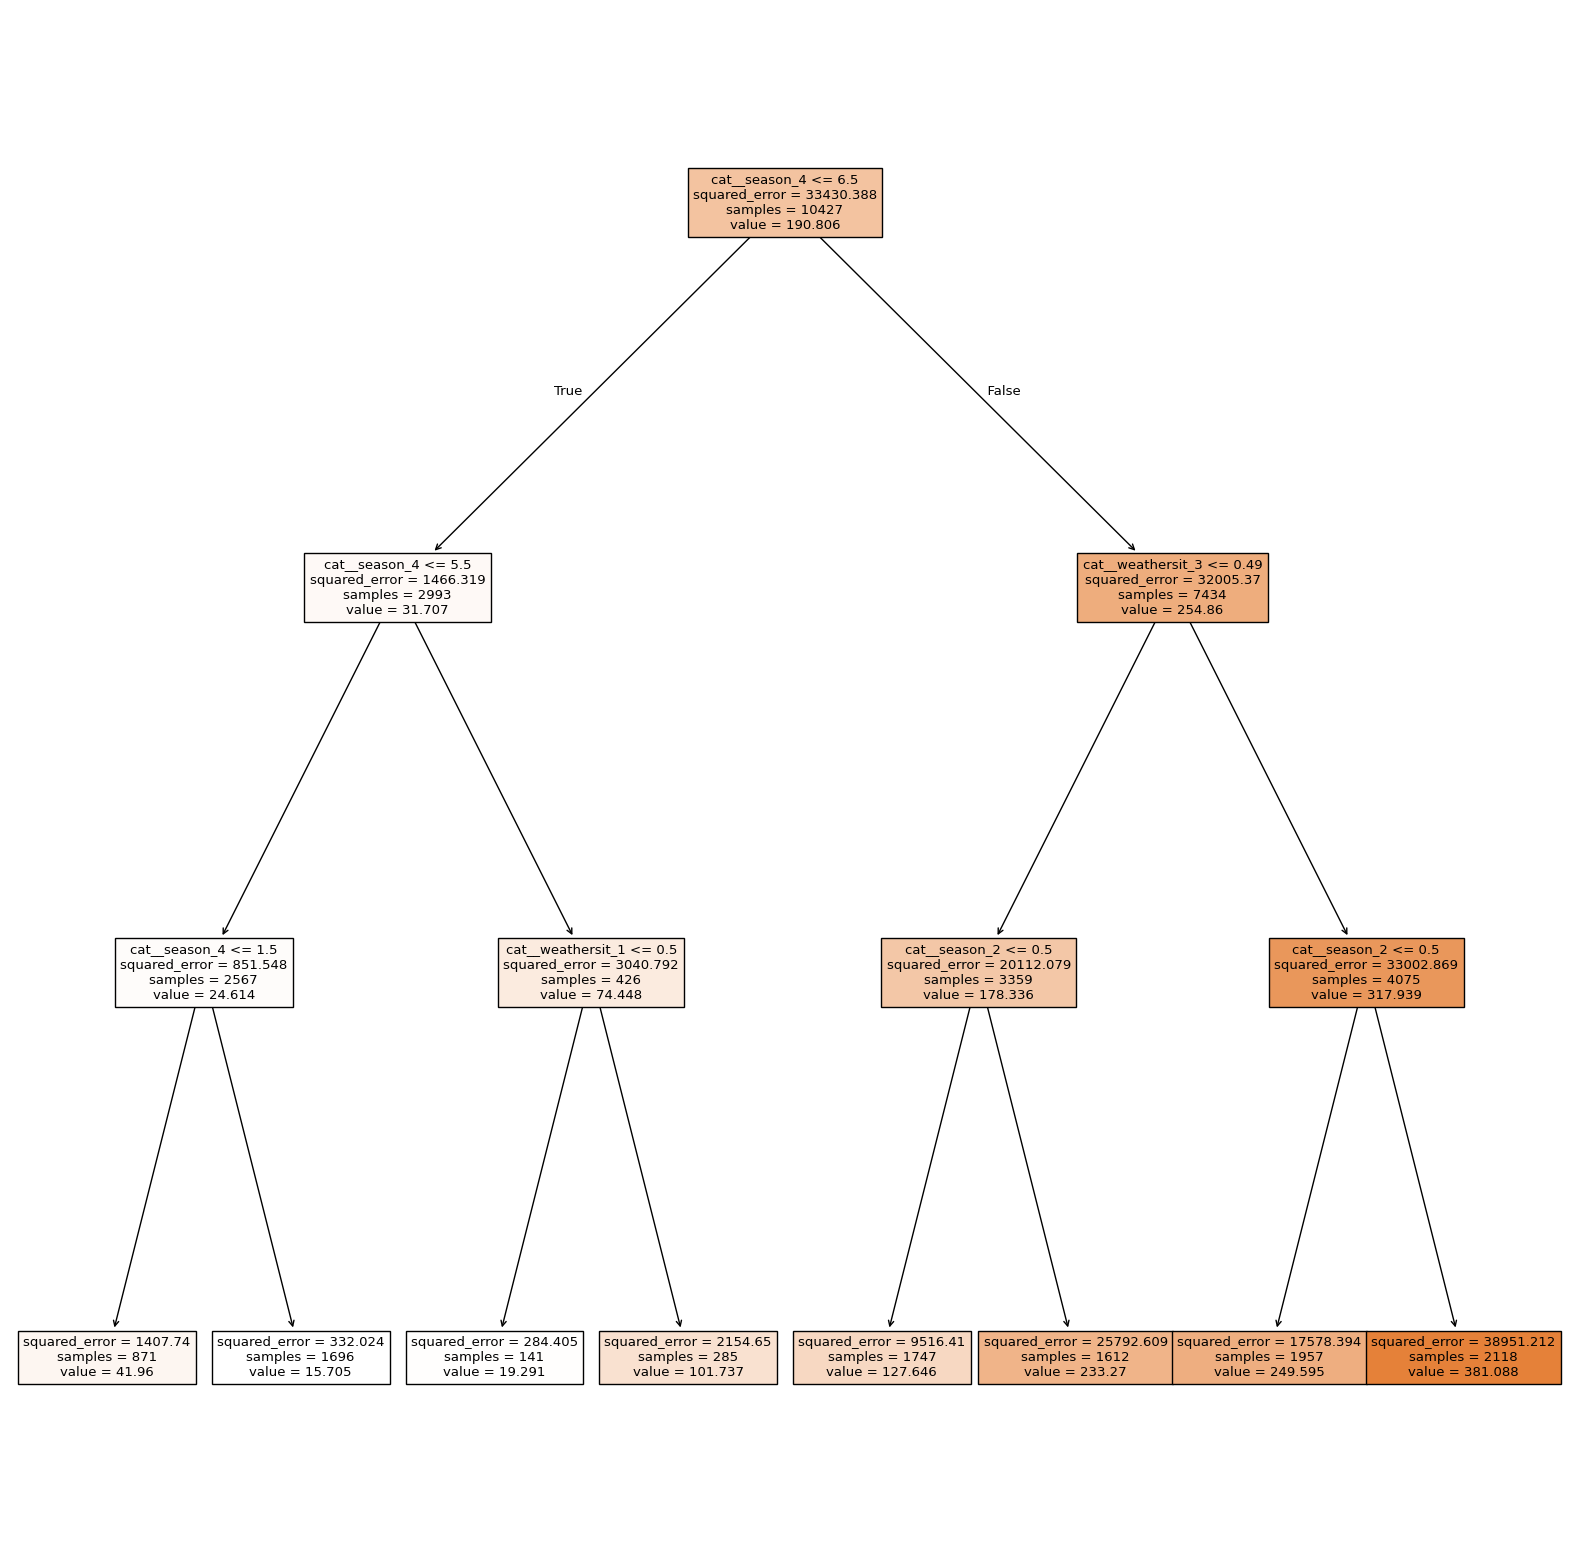

In [ ]:
#Display the decision tree
plt.figure(figsize=(20,20))
plot_tree(pipe_tree_3.named_steps['model'], feature_names = pipe_tree_3_proc.named_steps['transformer'].get_feature_names_out(), filled=True)
plt.show()

## Time Features

In [ ]:
# from https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#time-based-cross-validation

In [ ]:
weather.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


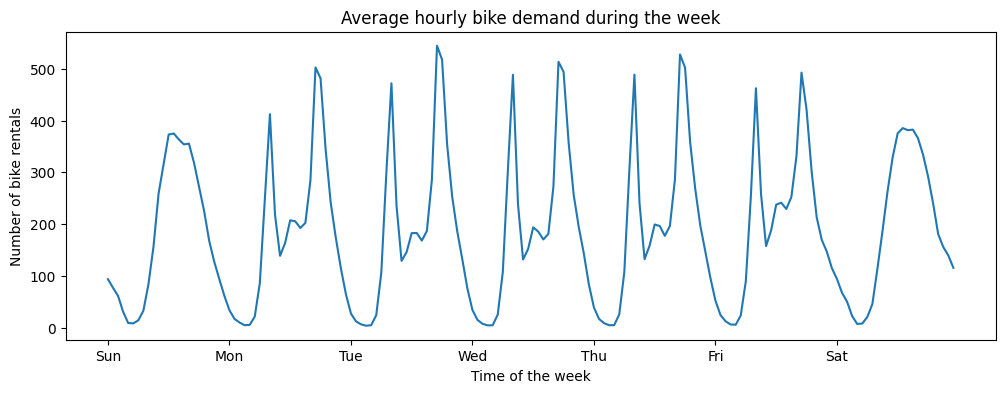

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday", "hr"])["cnt"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [ ]:
# they rescale the target to predict relative demand
# I don't do that here but we could
# y = df["count"] / df["count"].max()

In [ ]:
pipe_LR_proc = Pipeline(steps=[
    ('transformer', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
        ],
        remainder='passthrough'
    )),
    ('model', LinearRegression())
])

### Encoding time as categories (Onehot)

In [ ]:
pipe_LR_proc_onehot = Pipeline(steps=[
    ('transformer', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns),
            ('time', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ["hr", "weekday", "mnth"])
        ],
        remainder='passthrough'
    )),
    ('model', LinearRegression())
])

### Encoding time with sin / cos 

Intuition:

![sphx_glr_plot_cyclical_feature_engineering_004.png](attachment:sphx_glr_plot_cyclical_feature_engineering_004.png)

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
pipe_LR_proc_cos_sin = Pipeline(steps=[
    ('transformer', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns),
            ("month_sin", sin_transformer(12), ["mnth"]),
            ("month_cos", cos_transformer(12), ["mnth"]),
            ("weekday_sin", sin_transformer(7), ["weekday"]),
            ("weekday_cos", cos_transformer(7), ["weekday"]),
            ("hour_sin", sin_transformer(24), ["hr"]),
            ("hour_cos", cos_transformer(24), ["hr"]),
        ],
        remainder='passthrough'
    )),
    ('model', LinearRegression())
])

You can also use splines: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#periodic-spline-features

In [ ]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

In [ ]:
# comparing the LR models with different types of time features

pipe_LR_proc.fit(X.iloc[train_0], y.iloc[train_0])
naive_linear_predictions = pipe_LR_proc.predict(X.iloc[test_0])

pipe_LR_proc_onehot.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_linear_predictions = pipe_LR_proc_onehot.predict(X.iloc[test_0])

pipe_LR_proc_cos_sin.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_cossin_linear_predictions = pipe_LR_proc_cos_sin.predict(X.iloc[test_0])


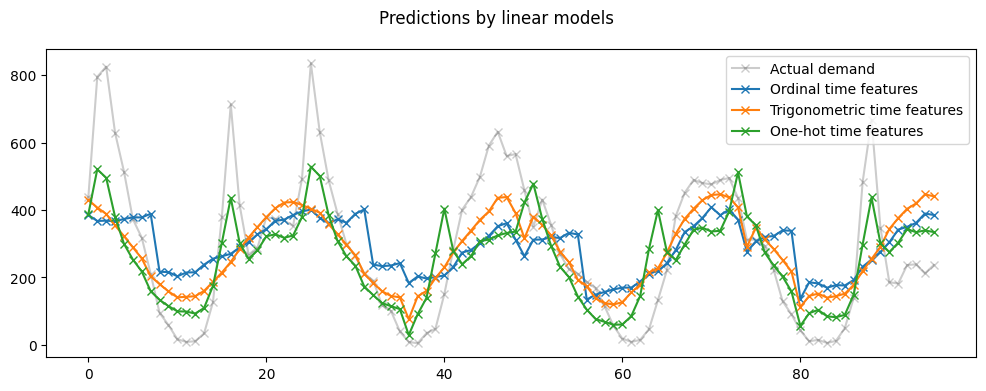

In [ ]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by linear models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)

ax.plot(
    naive_linear_predictions[last_hours], 
        "x-", 
        label="Ordinal time features"
)

ax.plot(
    cyclic_cossin_linear_predictions[last_hours],
    "x-",
    label="Trigonometric time features",
)

ax.plot(
    one_hot_linear_predictions[last_hours],
    "x-",
    label="One-hot time features",
)
_ = ax.legend()

### Results (time-based cv):

In [ ]:
model_scores = dict()
models = [pipe_LR, pipe_tree_3, pipe_tree_15, pipe_LR_proc, pipe_tree_3_proc, pipe_LR_proc_onehot, pipe_LR_proc_cos_sin]

for model in models:
    model_scores[model] = fit_eval_ts_cv(model, X, y, ts_cv)

In [ ]:
for pipe, score in model_scores.items():
    model_name = str(pipe.named_steps['model'])
    print(pipe)
    print(f"{score:.2f}")

Pipeline(steps=[('model', LinearRegression())])
33002.42
Pipeline(steps=[('model', DecisionTreeRegressor(max_depth=3, random_state=42))])
28363.22
Pipeline(steps=[('model',
                 DecisionTreeRegressor(max_depth=15, random_state=42))])
7789.60
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['season', 'yr',
                                                   'weathersit'])])),
                ('model', LinearRegression())])
32612.98
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown=